# Outline: Filament BAO

## 1. Read SDSS Data
- Load the SDSS dataset.
- Perform initial inspection and data cleaning if necessary.

## 2. Create Randoms
- Generate a set of random points within the survey volume.
- Ensure a uniform distribution for proper statistical analysis.

## 3. Assign Redshifts to Randoms
- Assign redshift values to the random catalog.
- Match the redshift distribution of the SDSS data.

## 4. Calculate ξ(s)
- Compute the two-point correlation function in redshift space.
- Use pair-counting techniques to measure clustering.




## 1) Read SDSS 
## 2) Create Randoms
## 3) Assign redshift to randoms

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

def build_cdf_from_line(data, vmin, vmax, num_points=10000):
 
  # Create a histogram of the redshifts
  hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
  bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
 
  def LinearFunction(x, a, b):
    return a * x + b

  def BreakFunction(x, a1, b1, a2, xb):
    yi = lambda x: LinearFunction( x, a1, b1)
    yo = lambda x: LinearFunction(xb, a1, b1) + ((x-xb) * a2)
    return np.piecewise(x, [x < xb, x >= xb], [yi, yo])

  bounds = [[-np.inf, -np.inf, -np.inf, vmin], [np.inf, np.inf, np.inf, vmax]]
 
  popt, pcov = curve_fit(BreakFunction, bin_centers, hist, bounds=bounds)
  assert(len(popt) == 4)
  print(popt)

  z_vals = np.linspace(vmin, vmax, num_points)
  pdf_vals = BreakFunction(z_vals, *popt)

  # Ensure the PDF is positive and normalized
  pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
  pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

  # Build the CDF
  cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
  cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

  # Create inverse CDF via interpolation
  cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
 
  return cdf_inv, z_vals, pdf_vals, cdf_vals

def build_cdf_from_parabola(data, vmin, vmax, deg, num_points=10000):
    # Create a histogram of the redshifts
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=deg)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals
  

def generate_random_radec(ra,dec,nside,nrand):

    # Total number of pixels in the map
    npix = hp.nside2npix(nside)

    # Initialize a mask array (1 = valid, 0 = invalid)
    mask = np.zeros(npix, dtype=int)

    # Convert RA, Dec to Healpix indices
    theta = np.radians(90 - dec)  # Declination to colatitude
    phi = np.radians(ra)          # Right Ascension to longitude
    pixels = hp.ang2pix(nside, theta, phi)

    # Mark these pixels as valid
    mask[pixels] = 1

    num_randoms = int(10e7)  # Number of random points

    # Generate uniform random RA, Dec
    ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
    u = np.random.uniform(-1, 1, num_randoms)
    dec_random_rad = np.arcsin(u)
    dec_random = np.rad2deg(dec_random_rad)
    #dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

    # Convert RA, Dec to Healpix indices
    theta_random = np.radians(90 - dec_random)
    phi_random = np.radians(ra_random)
    random_pixels = hp.ang2pix(nside, theta_random, phi_random)

    # Apply the mask
    valid_indices = mask[random_pixels] == 1
    ra_random = ra_random[valid_indices]
    dec_random = dec_random[valid_indices]

    #print(len(ra))
    #print(len(ra_random))

    return ra_random[:nrand], dec_random[:nrand]

def generate_random_red(redshift,nrand):

    # Read redshift distribution and apply to randoms
    # Build the inverse CDF from a smoothed KDE fit
    #cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(redshift, redshift.min(), redshift.max(), deg)
    cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_line(redshift, redshift.min(), redshift.max())

    # Generate random redshifts
    u = np.random.uniform(0, 1, nrand)
    red_random = cdf_inv_z(u)

    return red_random

# Parameters
sample = 'nyu'
h = 0.6774  # Hubble constant
zmin, zmax = 0.07, 0.2  # Redshift range
mag_max = -21.2
gr_min = 0.8
deg = 5
dist_min = 5.
dist_max = 10.


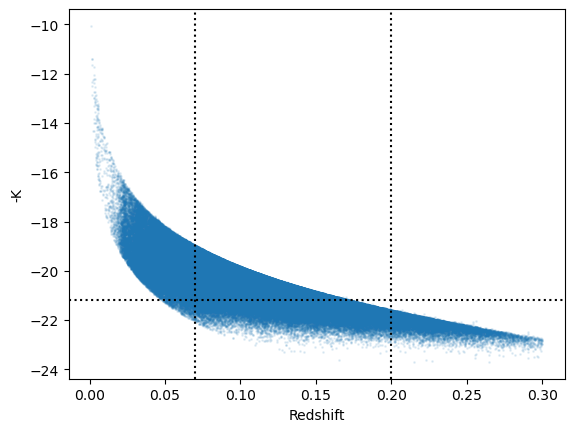

: 

In [ ]:

# Determine Sample
if sample == 'nyu': datafile = '../data/sdss_dr72safe0_zmin_0.000_zmax_0.300_sigma_5.0.csv'
elif sample == 'sdss': datafile = '../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv'

# Load galaxy data
cat_sdss_full = pd.read_csv(datafile)
cat_sdss_full['dist_fil'] /= h
cat_sdss_full = cat_sdss_full[cat_sdss_full['gr']>gr_min]
cat_sdss_z  = cat_sdss_full[(cat_sdss_full["red"] >= zmin)*(cat_sdss_full["red"] <= zmax)]
if sample == 'nyu':
    cat_sdss_z_mag = cat_sdss_z[cat_sdss_z['mag_abs_r']<mag_max]
else:
    cat_sdss_z_mag = cat_sdss_z[cat_sdss_z['mag_abs_r']-5*np.log10(h)<mag_max]

plt.scatter(cat_sdss_full['red'], cat_sdss_full['mag_abs_r'],color='C00',s=1,alpha=.1)

plt.axvline(zmin, color='k', linestyle=':')
plt.axvline(zmax, color='k', linestyle=':')
plt.axhline(mag_max, color='k', linestyle=':')

plt.xlabel('Redshift')
plt.ylabel('-K')
plt.show()

In [ ]:

ra = cat_sdss_z_mag['ra'].values  # Right Ascension
dec = cat_sdss_z_mag['dec'].values  # Declination
redshift = cat_sdss_z_mag['red'].values # Redshift

# Set the resolution (nside)
nside = 128  # Approx 55 arcmin resolution (adjust as needed)
nrand = 10*len(cat_sdss_z_mag) # Size of the randoms 

ra_random, dec_random = generate_random_radec(ra,dec,nside,nrand)
red_random = generate_random_red(redshift,nrand)
#random_data.to_csv(f'../data/random_sample_healpy_{nside}_{len(random_data)}.csv', index=False)


random_data = pd.DataFrame({
    'ra': ra_random,
    'dec': dec_random,
    'red': red_random
})


In [ ]:
print(len(cat_sdss_z_mag))
print(len(random_data))

42767
427670


### 3.1 Show angular and redshift distribution

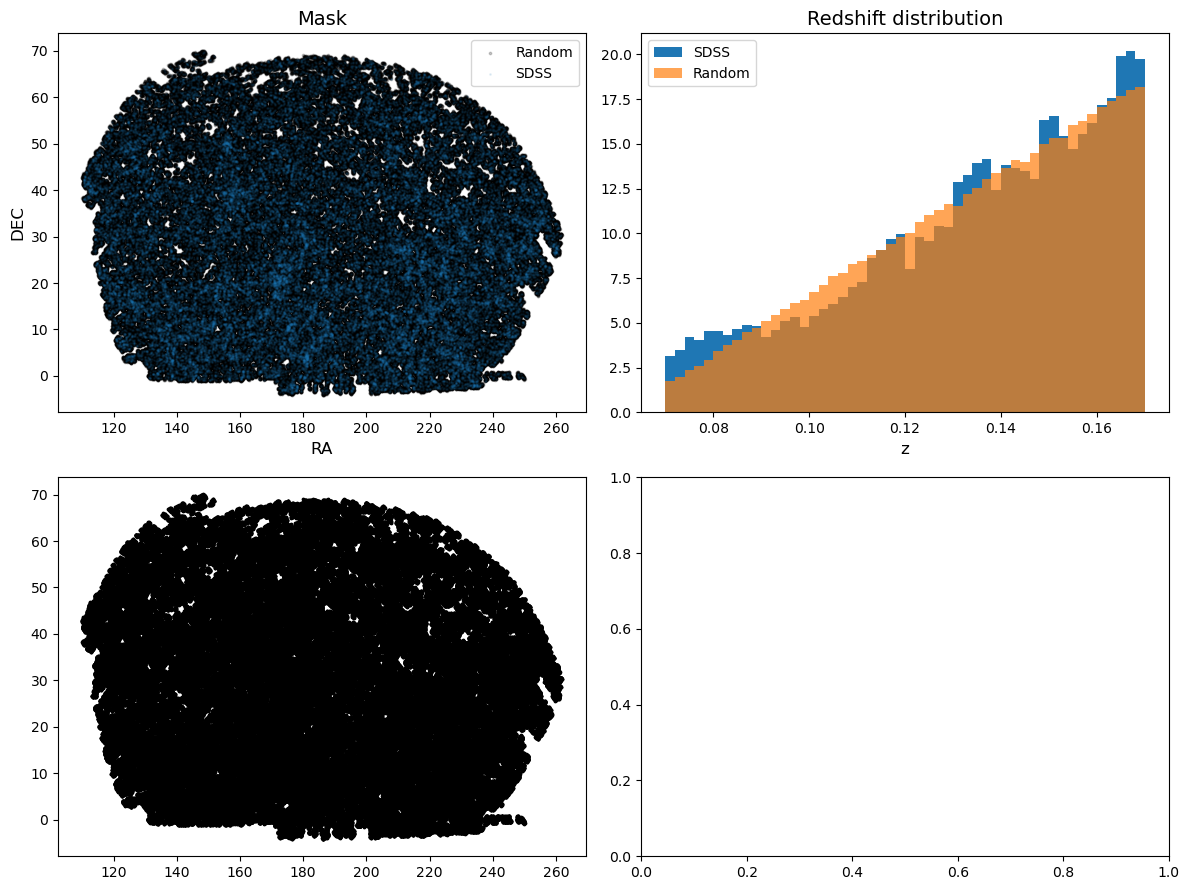

In [ ]:
import matplotlib.pyplot as plt

# Create the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharey=False)  # 1 row, 2 columns

# Plot left
axes[0,0].scatter(random_data['ra'],random_data['dec'],color='k',alpha=.2,s=3,label='Random')
axes[0,0].scatter(cat_sdss_z_mag['ra'], cat_sdss_z_mag['dec'],color='C00',s=1,alpha=.1,label='SDSS')

# Plot for just randoms
axes[1,0].scatter(random_data['ra'],random_data['dec'],color='k',alpha=1,s=3,label='Random')


# Plot right
axes[0,1].hist(cat_sdss_z_mag['red'],bins=50, color='C00', density=True, histtype='stepfilled', label='SDSS')
axes[0,1].hist(random_data['red'],bins=50, color='C01', density=True, histtype='stepfilled', alpha=0.7, label='Random')

# Customize each subplot
axes[0,0].set_title("Mask", fontsize=14)
axes[0,0].set_xlabel("RA", fontsize=12)
axes[0,0].set_ylabel("DEC", fontsize=12)
axes[0,0].tick_params(axis='both', labelsize=10)

axes[0,0].legend(loc=1)

axes[0,1].set_title("Redshift distribution", fontsize=14)
axes[0,1].set_xlabel("z", fontsize=12)
axes[0,1].tick_params(axis='both', labelsize=10)

axes[0,1].legend(loc=2)

# Adjust layout for readability
plt.tight_layout()

# Save or show the figure
#plt.savefig('1x2_plot_layout.png', dpi=300)  # Save as a high-res image
plt.show()


### 1.1) Show filament galaxies and non-filament galaxies

[121.87825359  -3.6008075  -66.1675367    0.1370117 ]
[ 2.18845947e+02 -1.62610760e+01  4.20327857e+00  1.69426765e-01]


/tmp/ipykernel_15855/2418536947.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF


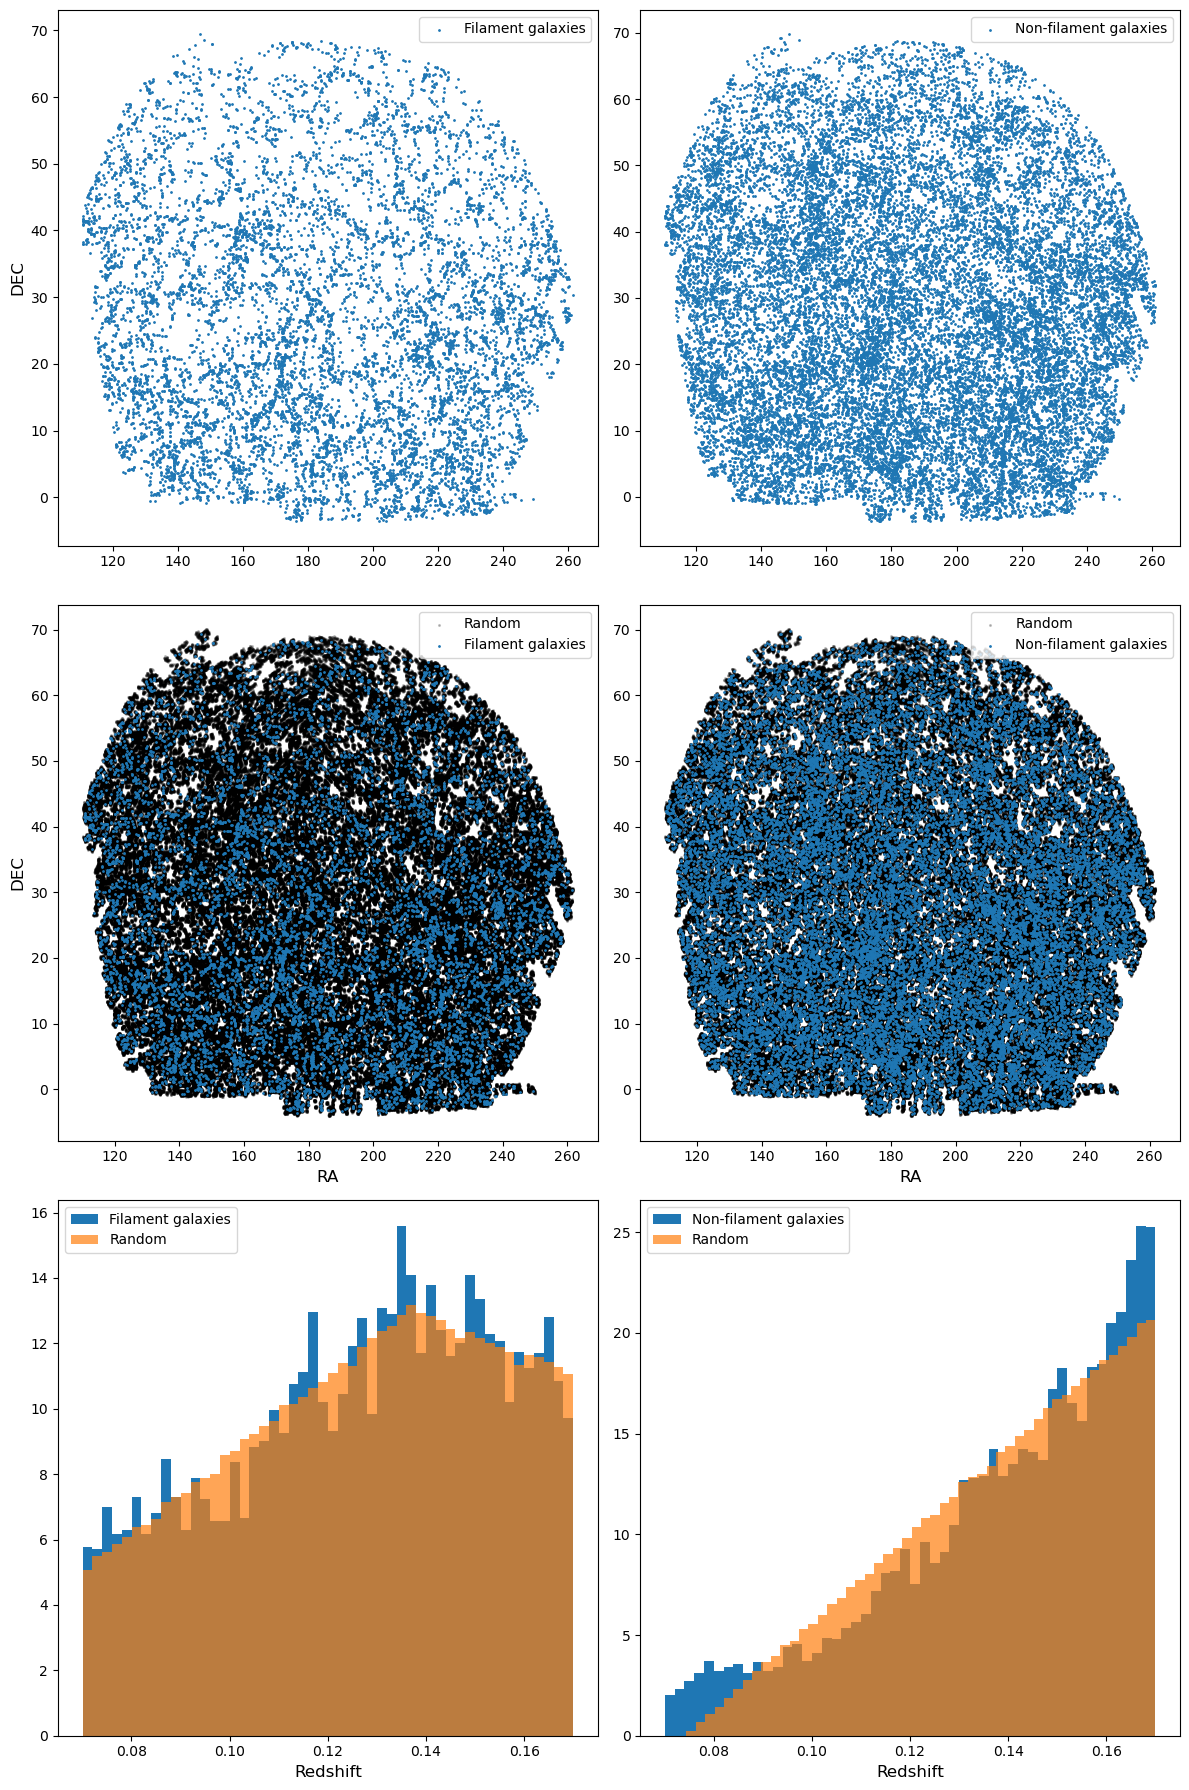

11285
25978


In [ ]:
import matplotlib.pyplot as plt

# Define filament and non-filament galaxies
filgxs = cat_sdss_z_mag[cat_sdss_z_mag['dist_fil']<=dist_min]
nonfilgxs = cat_sdss_z_mag[cat_sdss_z_mag['dist_fil']>dist_max]

# Create randoms for each sample
random_filgxs_red = generate_random_red(filgxs['red'].values,nrand)
random_filgxs = pd.DataFrame({
    'ra': random_data['ra'],
    'dec': random_data['dec'],
    'red': random_filgxs_red
}
)

random_nonfilgxs_red = generate_random_red(nonfilgxs['red'].values,nrand)
random_nonfilgxs = pd.DataFrame({
    'ra': random_data['ra'],
    'dec': random_data['dec'],
    'red': random_nonfilgxs_red
}
)


# Create the figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18), sharey=False) 

# Plot left
axes[0,0].scatter(filgxs['ra'],filgxs['dec'],color='C00',s=1,label='Filament galaxies')

# Plot right
axes[0,1].scatter(nonfilgxs['ra'],nonfilgxs['dec'],color='C00',s=1,label='Non-filament galaxies')

# Plots Middle
axes[1,0].scatter(random_filgxs['ra'],random_filgxs['dec'],color='k',alpha=.2,s=1.5,label='Random')
axes[1,1].scatter(random_nonfilgxs['ra'],random_nonfilgxs['dec'],color='k',alpha=.2,s=1.5,label='Random')

axes[1,0].scatter(filgxs['ra'],filgxs['dec'],color='C00',s=1,label='Filament galaxies')
axes[1,1].scatter(nonfilgxs['ra'],nonfilgxs['dec'],color='C00',s=1,label='Non-filament galaxies')

#Plots Bottom
axes[2,0].hist(filgxs['red'],bins=50, color='C00', density=True, histtype='stepfilled', label='Filament galaxies')
axes[2,0].hist(random_filgxs['red'],bins=50, color='C01', density=True, histtype='stepfilled', label='Random', alpha=0.7,)

axes[2,1].hist(nonfilgxs['red'],bins=50, color='C00', density=True, histtype='stepfilled', label='Non-filament galaxies')
axes[2,1].hist(random_nonfilgxs['red'],bins=50, color='C01', density=True, histtype='stepfilled', label='Random', alpha=0.7,)

# Customize each subplot
#axes[0].set_title("Mask", fontsize=14)
axes[1,0].set_xlabel("RA", fontsize=12)
axes[0,0].set_ylabel("DEC", fontsize=12)
axes[1,0].set_ylabel("DEC", fontsize=12)
axes[0,0].tick_params(axis='both', labelsize=10)


#axes[1].set_title("Redshift distribution", fontsize=14)
axes[1,1].set_xlabel("RA", fontsize=12)
axes[0,1].tick_params(axis='both', labelsize=10)

axes[0,0].legend(loc=1)
axes[0,1].legend(loc=1)
axes[1,0].legend(loc=1)
axes[1,1].legend(loc=1)
axes[2,0].legend(loc=2)
axes[2,1].legend(loc=2)


axes[2,0].set_xlabel("Redshift", fontsize=12)
axes[2,1].set_xlabel("Redshift", fontsize=12)

# Adjust layout for readability
plt.tight_layout()

# Save or show the figure
#plt.savefig('1x2_plot_layout.png', dpi=300)  # Save as a high-res image
plt.show()

print(len(filgxs))
print(len(nonfilgxs))

4.600749409506938 17.081679952760556 40.410806023029224


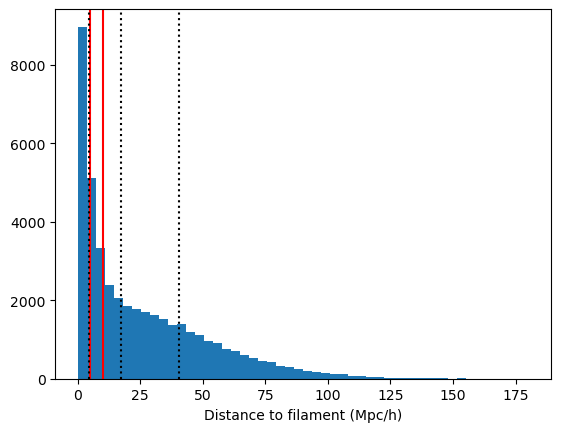

In [ ]:
plt.hist(cat_sdss_z_mag['dist_fil'],bins=50)

p25,p50,p75 = np.percentile(cat_sdss_z_mag['dist_fil'],[25,50,75])

print(p25,p50,p75)

plt.axvline(x=dist_min, color='r', linestyle='-')
plt.axvline(x=dist_max, color='r', linestyle='-')

plt.axvline(x=p25, color='k', linestyle=':')
plt.axvline(x=p50, color='k', linestyle=':')
plt.axvline(x=p75, color='k', linestyle=':')

plt.xlabel('Distance to filament (Mpc/h)')
#plt.xscale('log')
plt.show()

## Calculate $\xi(s)$

In [ ]:
######################
minsep = 10.      # Min theta
maxsep = 150.      # Max theta
nbins = 30        # Bins in theta
nbootstrap = 0  # No. of bootstrap resampling
brute = False     # Brute force for TreeCorr
npatch = 0

config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            #"sep_units": 'degree', \
            "bin_type": 'Linear', \
            #"brute": brute, \
            #"metric": 'Arc', \
            #"var_method": 'bootstrap', \
            #"num_bootstrap": nbootstrap,\
            }
######################

import numpy as np
import pandas as pd
import treecorr
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=h*100, Om0=0.3089)

def H(ra, dec, z):

  ra  = np.array(ra,  dtype=np.float32) 
  dec = np.array(dec, dtype=np.float32) 
  z   = np.array(z,   dtype=np.float32) 

  r = np.float32(cosmo.comoving_distance(z).value)
  x = r*np.cos(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  y = r*np.sin(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  z = r*np.sin(np.deg2rad(dec))
  return x, y, z

def calculate_xi(data,randoms,config,sample=None):

  randoms["x"], randoms["y"], randoms["z"] = H(randoms["ra"], randoms["dec"], randoms["red"])
  data.loc[:, ('x')],data.loc[:, ('y')],data.loc[:, ('z')] = H(data["ra"], data["dec"], data["red"])


  # TreeCorr Catalogues
  dd = treecorr.NNCorrelation(config)
  dr = treecorr.NNCorrelation(config)
  rr = treecorr.NNCorrelation(config)
  #rd = treecorr.NNCorrelation(config)

  rcat = treecorr.Catalog(x=randoms['x'], y=randoms['y'], z=randoms['z'])
  gcat = treecorr.Catalog(x=data['x'], y=data['y'], z=data['z'])

  dd.process(gcat)
  rr.process(rcat)
  dr.process(gcat,rcat)

  xi, varxi = dd.calculateXi(rr=rr,dr=dr)

  if sample!=None:
    rr.write('../data/rr.txt')
    dd.write('../data/dd.txt')
    dr.write('../data/dr.txt')
  else:
    rr.write(f'../data/rr_{sample}.txt')
    dd.write(f'../data/dd_{sample}.txt')
    dr.write(f'../data/dr_{sample}.txt')
  return xi, varxi, dd.meanr

print('Calculating xi')
xi, varxi, s = calculate_xi(cat_sdss_z_mag, random_data, config)

print('Calculating xi_fil')
xi_fil, varxi_fil, s_fil = calculate_xi(filgxs, random_filgxs, config)

print('Calculating xi_nonfil')
xi_nonfil, varxi_nonfil, s_nonfil = calculate_xi(nonfilgxs, random_nonfilgxs, config)


Calculating xi
Calculating xi_fil
Calculating xi_nonfil


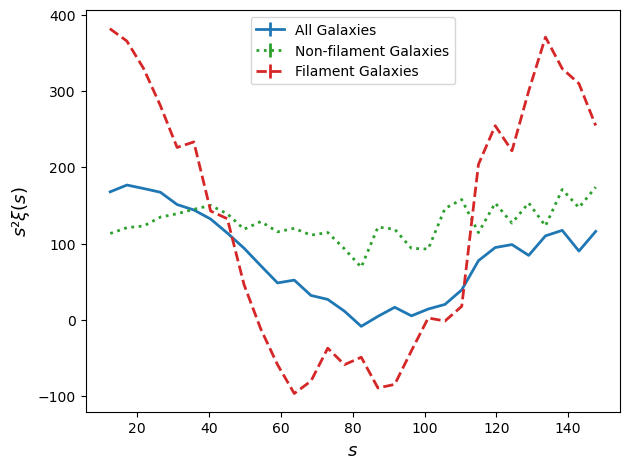

[ 12.43544583  17.10701416  21.76926575  26.42768536  31.08009823
  35.73941786  40.40332147  45.06268274  49.72022937  54.38780496
  59.05152538  63.71476017  68.37359853  73.04186706  77.70531581
  82.37026962  87.03252741  91.70030659  96.36181154 101.02832594
 105.69141703 110.36101559 115.02309161 119.69031973 124.35438313
 129.01857699 133.68812023 138.35088809 143.01867037 147.68390198]


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
fslabel = 13

sig = np.sqrt(varxi)
sig_nonfil = np.sqrt(varxi_nonfil)
sig_fil = np.sqrt(varxi_fil)

#s = dd.meanr
plt.errorbar(s, xi*s**2, yerr=sig, color='C00', lw=2, label='All Galaxies')
plt.errorbar(s_nonfil, xi_nonfil*s_nonfil**2, yerr=sig_nonfil, color='C02', lw=2, label='Non-filament Galaxies', ls=':')
plt.errorbar(s_fil, xi_fil*s_fil**2, yerr=sig_fil, color='C03', lw=2, label='Filament Galaxies', ls='--')

plt.xlabel(r'$s$', fontsize = fslabel)
plt.ylabel(r'$s²\xi(s)$', fontsize = fslabel)

#plt.xlim(10, 130)

plt.legend()

plt.tight_layout()

plt.show()

print(s)

plotname = f'../plots/xi_s_mag{mag_max}_z{zmin}-{zmax}_distfil{dist_min}-{dist_max}_color{gr_min}.png'
plt.savefig(plotname)

In [ ]:
cat_sdss_z_mag.keys()

Index(['indx', 'sector', 'mregion', 'ra', 'dec', 'cz', 'fgotten',
       'selection_fn', 'mag_abs_u', 'mag_abs_g', 'mag_abs_r', 'mag_abs_i',
       'mag_abs_z', 'mu_50', 'r50_r90', 'red', 'gr', 'lum_g', 'lum_r', 'x',
       'y', 'z', 'idfil', 'idseg', 'long_fil', 'long_seg', 'lum_r_fil',
       'lum_r_seg', 'dist_fil'],
      dtype='object')

In [ ]:
print(len(cat_sdss_z_mag))
print(len(cat_sdss_z_mag[cat_sdss_z_mag['gr']>.8]))

42767
42767
